# Librerias

In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact, mannwhitneyu


# Funciones

In [255]:
def load_data(path):
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip().str.lower()
    return df

def get_col(df, *candidates):
    """
    Returns the first column found in df.columns
    that matches one of the candidate names.
    """
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"Ninguna columna encontrada entre: {candidates}")

def normalize_diagnostico(df):
    def diag_type(x):
        if pd.isna(x):
            return np.nan
        x = x.lower()
        if "tac" in x or "eco" in x or "ima" in x:
            return "imagen"
        return "clinico"
    df["diagnostico_tipo"] = df["diagnostico"].apply(diag_type)
    return df

def normalize_diastasis(df):
    def parse_d(x):
        if pd.isna(x) or x.lower() == "no":
            return 0
        if ">5" in x:
            return 6
        m = re.search(r"(\d+)", x)
        return int(m.group(1)) if m else np.nan

    df["diastasis_cm"] = df["diastasis"].astype(str).apply(parse_d)
    df["tiene_diastasis"] = df["diastasis_cm"] > 0
    return df

def normalize_cirugia_adicional(df, col="cirugia adicional"):
    df["cirugia_adicional_flag"] = (
        df[col]
        .astype(str)
        .str.strip()
        .str.upper()
        .ne("NO")
    )
    return df

def normalize_hernia_tipo(df):

    col = "tipo de hernia"

    def clean(x):
        if pd.isna(x):
            return ""
        return re.sub(r"\s+", " ", x.lower().strip())

    def tipo(x):
        x = clean(x)

        if "umb" in x:
            return "umbilical"
        if "incisi" in x or "insic" in x:
            return "incisional"
        if "ventral" in x:
            return "ventral"

        return "no_especificado"

    def primaria(x):
        x = clean(x)
        return "primaria" in x

    def recidivada(x):
        x = clean(x)
        return "recidiv" in x

    df["hernia_tipo"] = df[col].apply(tipo)
    df["hernia_primaria"] = df[col].apply(primaria)
    df["hernia_recidivada"] = df[col].apply(recidivada)

    return df

def add_hernia_origen_categoria(df):
    def origen(row):
        # Recidiva explícita siempre gana
        if row["hernia_recidivada"]:
            return "recidivada"

        # Las incisionales sin recidiva son primarias por definición
        if row["hernia_tipo"] == "incisional":
            return "primaria"

        # Primaria explícita
        if row["hernia_primaria"]:
            return "primaria"

        return "no_especificado"

    df["hernia_origen"] = df.apply(origen, axis=1)
    return df


def parse_ehs(df):
    def parse(x):
        if pd.isna(x):
            return (np.nan, np.nan)
        m = re.search(r"M(\d)W(\d)", x)
        return (int(m.group(1)), int(m.group(2))) if m else (np.nan, np.nan)

    df[["ehs_m", "ehs_w"]] = df["clasificación ehs"].apply(lambda x: pd.Series(parse(x)))
    return df

def detect_pvp(row):
    return "pvp" in str(row["tipo de hernia"]).lower()


def normalize_hospitalizacion(df, col="tiempo de hospitalización(horas)"):

    def categoria(x):
        if pd.isna(x):
            return "no_especificado"

        x = x.lower()

        if "ambulator" in x:
            return "ambulatorio"

        if re.search(r"\b1\s*n", x):
            return "1_noche"
        if re.search(r"\b2\s*n", x):
            return "2_noches"
        if re.search(r"\b3\s*n|\b4\s*n|\b5\s*n", x):
            return "3+_noches"

        return "no_especificado"

    def duracion_horas(x):
        if pd.isna(x):
            return np.nan

        m = re.search(r"\((\d+):(\d+)\)", x)
        if not m:
            return np.nan

        h, mnt = int(m.group(1)), int(m.group(2))
        return h + mnt / 60

    df["hosp_cat"] = df[col].apply(categoria)
    df["hosp_horas"] = df[col].apply(duracion_horas)

    return df


def normalize_complicaciones(df):

    col = get_col(
        df,
        "complicacion post op a 30 dias",
        "complicacion post op a 30 días"
    )

    def comp(x):
        if pd.isna(x):
            return "sin_info"

        x = x.lower().strip()

        # NO complication
        if x.startswith("no"):
            return "no"

        # SI but unspecified
        if x.startswith("si") and "(" not in x:
            return "otra"

        # Specific complications
        if "seroma" in x:
            return "seroma"
        if "hematoma" in x:
            return "hematoma"
        if "infe" in x:
            return "infeccion"
        if "dolor" in x:
            return "dolor"
        if "perfor" in x:
            return "perforacion"
        if "alerg" in x or "rechazo" in x or "reaccion" in x:
            return "reaccion_sutura"

        return "Desconocido"

    df["comp_30d"] = df[col].apply(comp)

    df["tuvo_complicacion"] = df["comp_30d"].isin(
        ["seroma", "hematoma", "infeccion", "dolor", "perforacion", "reaccion_sutura", "Desconocido"]
    )

    return df




def normalize_conversion(df, col="conversion"):
    def conv(x):
        if pd.isna(x):
            return False
        x = str(x).lower().strip()
        return x not in ["no", "0", "false"]

    df["cirugia_compartida"] = df[col].apply(conv)
    return df

def normalize_sexo(df):
    def sex(x):
        if pd.isna(x):
            return "no_especificado"
        x = x.lower().strip()
        if x.startswith("m"):
            return "masculino"
        if x.startswith("f"):
            return "femenino"
        return "no_especificado"

    df["sexo_norm"] = df["sexo"].apply(sex)
    return df
def normalize_recurrencia(df, col="recurrencia"):
    def parse(x):
        if pd.isna(x):
            return {
                "tiene_recurrencia": False,
                "recurrencia_test": False,
                "recurrencia_imagen": False,
                "recurrencia_tipo": "desconocido"
            }

        x = x.lower().strip()

        es_si = x.startswith("si")
        es_no = x.startswith("no")

        por_test = "test" in x
        por_imagen = "imagen" in x

        return {
            "tiene_recurrencia": es_si,
            "recurrencia_test": por_test and es_si,
            "recurrencia_imagen": por_imagen and es_si,
            "recurrencia_tipo":
                "imagen+test" if es_si and por_test and por_imagen else
                "imagen" if es_si and por_imagen else
                "test" if es_si and por_test else
                "no"
        }

    parsed = df[col].apply(parse).apply(pd.Series)

    for c in parsed.columns:
        df[c] = parsed[c]

    return df


def apply_filters(df):
    df = df[df["edad"] >= 18]

    # Excluir SOLO los que no tienen ningún tipo de seguimiento
    df = df[
        ~(
            df["llamados"].str.contains("no contesta", na=False)
            & df["imagen postop"].str.lower().isin(["no", "", np.nan])
            & df["recurrencia"].isna()
        )
    ]

    return df

def to_float(series):
    return pd.to_numeric(
        series.astype(str).str.replace(",", ".", regex=False),
        errors="coerce"
    )

def basic_means(df):
    return {
        "media_edad": to_float(df["edad"]).mean(),
        "media_imc": to_float(df["imc"]).mean(),
        "media_seguimiento_meses": to_float(df["seg (meses)"]).mean(),
        "media_tamaño_hernia": to_float(df["tamaño de la hernia (cm)"]).mean()
    }



def percentages(series):
    return series.value_counts(normalize=True) * 100

def plot_bar(series, title):
    ax = series.value_counts(normalize=True).plot(kind="bar")

    plt.ylabel("%")
    plt.title(title)

    # Add annotations
    for p in ax.patches:
        value = p.get_height()
        ax.annotate(
            f"{value*100:.1f}%",
            (p.get_x() + p.get_width() / 2, value),
            ha="center",
            va="bottom"
        )

    plt.show()

def compare_groups(df, group_col, outcome_col):
    return pd.crosstab(df[group_col], df[outcome_col], normalize="index") * 100

def report_group_n(df, group_col):
    return (
        df[group_col]
        .value_counts()
        .rename("N")
        .to_frame()
    )


def plot_group_proportion(df, group_col, outcome_col, title):
    prop = (
        df.groupby(group_col)[outcome_col]
        .mean()
        .sort_index()
        * 100
    )

    prop.plot(kind="bar")
    plt.ylabel("%")
    plt.title(title)
    plt.ylim(0, max(prop.max() * 1.2, 10))
    plt.show()

def plot_group_proportion_with_n(df, group_col, outcome_col, title):
    prop = df.groupby(group_col)[outcome_col].mean() * 100
    n = df[group_col].value_counts()

    ax = prop.plot(kind="bar")
    plt.ylabel("%")
    plt.title(title)
    plt.ylim(0, max(prop.max() * 1.2, 10))

    for i, g in enumerate(prop.index):
        ax.text(i, prop[g] + 1, f"N={n[g]}", ha="center", fontsize=9)

    plt.show()


def normalize_tiempo_qx(df, col="tiempo qx"):
    def parse_hhmm(x):
        if pd.isna(x):
            return np.nan
        try:
            h, m = str(x).split(":")
            return int(h) * 60 + int(m)
        except:
            return np.nan

    df["tiempo_qx_min"] = df[col].apply(parse_hhmm)
    return df
def plot_stacked_bar(df, group_col, outcome_col, title):
    """
    Stacked bar chart showing % and absolute counts per group.
    """

    # Counts
    counts = pd.crosstab(df[group_col], df[outcome_col])

    # Percentages within group
    perc = counts.div(counts.sum(axis=1), axis=0) * 100

    fig, ax = plt.subplots(figsize=(6, 4))

    bottom = np.zeros(len(perc))

    for outcome in perc.columns:
        bars = ax.bar(
            perc.index.astype(str),
            perc[outcome],
            bottom=bottom,
            label=str(outcome)
        )

        # Annotate counts inside bars
        for i, bar in enumerate(bars):
            n = counts.loc[perc.index[i], outcome]
            if n > 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bottom[i] + bar.get_height() / 2,
                    f"{int(n)}",
                    ha="center",
                    va="center",
                    fontsize=9,
                    color="white" if bar.get_height() > 15 else "black"
                )

        bottom += perc[outcome].values

    # Labels
    group_n = df[group_col].value_counts()
    x_labels = [f"{g}\n(N={group_n[g]})" for g in perc.index]
    ax.set_xticks(range(len(x_labels)))
    ax.set_xticklabels(x_labels)

    ax.set_ylabel("% dentro del grupo")
    ax.set_title(title)
    ax.legend(title=outcome_col)

    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

def plot_tiempo_qx_hist(df, col="tiempo_qx_min"):
    data = df[col].dropna()

    plt.figure(figsize=(6, 4))
    plt.hist(data, bins=20)
    plt.xlabel("Tiempo quirúrgico (min)")
    plt.ylabel("Número de pacientes")
    plt.title("Histograma del tiempo quirúrgico")
    plt.tight_layout()
    plt.show()

def plot_tiempo_qx_box(df, col="tiempo_qx_min"):
    data = df[col].dropna()

    plt.figure(figsize=(5, 4))
    plt.boxplot(data, vert=False)
    plt.xlabel("Tiempo quirúrgico (min)")
    plt.title("Distribución del tiempo quirúrgico")
    plt.tight_layout()
    plt.show()

def fisher_from_crosstab(tab):
    """
    tab: pd.DataFrame 2x2
    """
    table = tab.values
    or_val, p = fisher_exact(table)
    return or_val, p


def risk_diff(tab):
    """
    Risk difference (row1 - row0) assuming:
    rows = exposure (False, True)
    cols = outcome (False, True)
    """
    risk0 = tab.iloc[0,1] / tab.iloc[0].sum()
    risk1 = tab.iloc[1,1] / tab.iloc[1].sum()
    return risk1, risk0, risk1 - risk0


def print_cirugia_adicional_summary(df, col="cirugia adicional"):
    counts = df[col].value_counts()
    perc = df[col].value_counts(normalize=True).mul(100).round(2)

    summary = (
        pd.concat([counts, perc], axis=1)
        .rename(columns={0: "N", 1: "%"})
    )

    print("\n===== CIRUGÍA ADICIONAL ASOCIADA =====")
    print(summary)
    print("\nCirugía única (NO):", counts.get("NO", 0))
    print("Cirugía adicional (total):", counts.sum() - counts.get("NO", 0))
    print(
        "Porcentaje cirugía adicional:",
        round(df["cirugia_adicional_flag"].mean() * 100, 2),
        "%"
    )





# Cargar datos

In [ ]:
path= "../data"
df = load_data(path + "/tapp_ventral_analisis_final.csv")
print(df.shape)
df.head()

In [257]:
df["cirugia adicional"].value_counts()

cirugia adicional
NO                  150
COLELAP               3
TEP / E-TEP           3
OTRO                  2
PLICATURA RECTOS      2
COLE + PLICATURA      1
COLE + TEP            1
Name: count, dtype: int64

# Limpieza y normalización

In [258]:
df = normalize_sexo(df)
df = normalize_diagnostico(df)
df = normalize_diastasis(df)
df = normalize_hernia_tipo(df)
df = add_hernia_origen_categoria(df)
df = parse_ehs(df)
df = normalize_complicaciones(df)
df = normalize_cirugia_adicional(df)
df = normalize_recurrencia(df)
df = normalize_conversion(df)
df = normalize_hospitalizacion(df)
df_filtered = normalize_tiempo_qx(df)




In [259]:
df_filtered.shape

(162, 59)

# Resultados

## Resultados numéricos

In [260]:
# ======================================================
# COHORTE
# ======================================================

print("===== COHORTE TOTAL =====")
print(f"N total: {len(df_filtered)}")


# ======================================================
# VARIABLES DEMOGRÁFICAS
# ======================================================

means = basic_means(df_filtered)

print("\n===== VARIABLES DEMOGRÁFICAS =====")
print(f"Edad media (años): {means['media_edad']:.2f}")
print(f"IMC medio: {means['media_imc']:.2f}")
print(
    f"Seguimiento medio: {means['media_seguimiento_meses']:.2f} meses "
    f"({means['media_seguimiento_meses']/12:.2f} años)"
)
print("\n===== SEXO =====")
print(df_filtered["sexo"].value_counts())
print(percentages(df_filtered["sexo"]).round(2))

print(f"Tamaño medio de hernia (cm): {means['media_tamaño_hernia']:.2f}")


# ======================================================
# DIAGNÓSTICO Y DIASTASIS
# ======================================================

print("\n===== DIAGNÓSTICO PREOPERATORIO =====")
print(percentages(df_filtered["diagnostico_tipo"]).round(2))
print(f"N evaluados: {df_filtered['diagnostico_tipo'].notna().sum()}")

print("\n===== DIASTASIS =====")
print(f"Sin diástasis (%): {(~df_filtered['tiene_diastasis']).mean()*100:.2f}")
print(f"Con diástasis (%): {df_filtered['tiene_diastasis'].mean()*100:.2f}")
print("Con diástasis:", df_filtered["tiene_diastasis"].sum())
print("Sin diástasis:", (~df_filtered["tiene_diastasis"]).sum())

# ======================================================
# TIPO Y ORIGEN DE HERNIA
# ======================================================

print("\n===== TIPO DE HERNIA (subtipo dentro de hernia ventral) =====")
print(percentages(df_filtered["hernia_tipo"]).round(2))
print(f"N total: {len(df_filtered)}")

print("\n===== ORIGEN DE LA HERNIA (COHORTE TOTAL TAPP) =====")
print(percentages(df_filtered["hernia_origen"]).round(2))
print(f"N total: {len(df_filtered)}")


# ======================================================
# HERNIA INCISIONAL
# ======================================================

inc = df_filtered[df_filtered["hernia_tipo"] == "incisional"]

print("\n===== HERNIA INCISIONAL =====")
print(f"Total (N): {len(inc)}")

print("Origen (%):")
print(percentages(inc["hernia_origen"]).round(2))

print(
    f"De trocar (%): "
    f"{inc['tipo de hernia'].str.contains('trocar', case=False, na=False).mean()*100:.2f}"
)

print(
    f"Otras (lumbar, spigel, pfannenstiel, etc) (%): "
    f"{inc['tipo de hernia'].str.contains('lumbar|spiguel|spigel|pfann', case=False, na=False).mean()*100:.2f}"
)


# ======================================================
# HERNIA UMBILICAL
# ======================================================

umb = df_filtered[df_filtered["hernia_tipo"] == "umbilical"]

print("\n===== HERNIA UMBILICAL =====")
print(f"Total (N): {len(umb)}")

print("Origen (%):")
print(percentages(umb["hernia_origen"]).round(2))

umb_rec = umb[umb["hernia_origen"] == "recidivada"].copy()
umb_rec["usa_pvp"] = umb_rec.apply(detect_pvp, axis=1)
no_spec = df[df["hernia_tipo"] == "no_especificado"]

print("N no_especificado:", len(no_spec))
print("\nValores originales en 'tipo de hernia' que quedaron no_especificados:\n")
print(no_spec["tipo de hernia"].value_counts())
print("\nUmbilicales recidivadas:")
print(f"Total recidivadas (N): {len(umb_rec)}")
print(f"Con malla PVP (%): {umb_rec['usa_pvp'].mean()*100:.2f}")
print(f"Con malla PVP (N): {umb_rec['usa_pvp'].sum()} / {len(umb_rec)}")


# ======================================================
# CLASIFICACIÓN EHS
# ======================================================

print("\n===== CLASIFICACIÓN EHS (M) =====")
print(percentages(df_filtered["ehs_m"]).round(2))



# ======================================================
# TIEMPO QUIRÚRGICO
# ======================================================

print("\n===== TIEMPO QUIRÚRGICO =====")
print(f"Promedio (min): {df_filtered['tiempo_qx_min'].mean():.2f}")
print(f"Mediana (min): {df_filtered['tiempo_qx_min'].median():.2f}")
print(
    "IQR (min):",
    df_filtered["tiempo_qx_min"].quantile([0.25, 0.75]).round(2).to_dict()
)


# ======================================================
# HOSPITALIZACIÓN
# ======================================================

print("\n===== HOSPITALIZACIÓN =====")
print(percentages(df_filtered["hosp_cat"]).round(2))
print(f"N total: {df_filtered['hosp_cat'].notna().sum()}")


# ======================================================
# COMPLICACIONES
# ======================================================

print("\n===== COMPLICACIONES POSTQUIRÚRGICAS =====")
print(f"Pacientes con complicaciones (%): {df_filtered['tuvo_complicacion'].mean()*100:.2f}")

print("\nComplicaciones a 30 días (%):")
print(percentages(df_filtered["comp_30d"]).round(2))


# ======================================================
# CLAVIEN
# ======================================================

print("\n===== CLASIFICACIÓN CLAVIEN =====")
print(percentages(df_filtered["complicacion clavien (i-v)"].dropna()).round(2))

#######CIRUGÍA ADICIONAL
print_cirugia_adicional_summary(df_filtered)

# ======================================================
# RECURRENCIA
# ======================================================

print("\n===== RECURRENCIA =====")

print("Distribución por método (%):")
print(percentages(df_filtered["recurrencia_tipo"]).round(2))

rec_total = df_filtered["tiene_recurrencia"].mean() * 100
print(f"Recurrencia total (%): {rec_total:.2f}")

# Falsos positivos: test (+) con imagen (-)
false_pos = df_filtered[
    (df_filtered["recurrencia_test"] == True) &
    (df_filtered["recurrencia_imagen"] == False)
]

print(f"Test positivo con imagen negativa (N): {len(false_pos)}")


# ======================================================
# CIRUGÍA ASOCIADA (CIRUGÍA COMPARTIDA)
# ======================================================
# conversion = cirugía adicional / combinada

df_filtered["cirugia_compartida"] = (
    df_filtered["conversion"]
    .astype(str)
    .str.lower()
    .ne("no")
)

# ======================================================
# URGENCIA VS ELECTIVA
# ======================================================

print("\n===== URGENCIA VS ELECTIVA =====")

print("Recurrencia (%):")
print(compare_groups(df_filtered, "urgencia", "tiene_recurrencia").round(2))

print("Complicaciones (%):")
print(compare_groups(df_filtered, "urgencia", "tuvo_complicacion").round(2))

print("\nN por grupo – urgencia:")
print(df_filtered["urgencia"].value_counts())


# ======================================================
# CIRUGÍA COMPARTIDA VS CIRUGÍA SOLA
# ======================================================

print("\n===== CIRUGÍA COMPARTIDA VS SOLA =====")

print("Recurrencia (%):")
print(compare_groups(df_filtered, "cirugia_compartida", "tiene_recurrencia").round(2))

print("Complicaciones (%):")
print(compare_groups(df_filtered, "cirugia_compartida", "tuvo_complicacion").round(2))

print("\nN por grupo – cirugía compartida:")
print(df_filtered["cirugia_compartida"].value_counts())


===== COHORTE TOTAL =====
N total: 162

===== VARIABLES DEMOGRÁFICAS =====
Edad media (años): 48.46
IMC medio: 27.69
Seguimiento medio: 93.94 meses (7.83 años)

===== SEXO =====
sexo
MASCULINO    110
FEMENINO      52
Name: count, dtype: int64
sexo
MASCULINO    67.9
FEMENINO     32.1
Name: proportion, dtype: float64
Tamaño medio de hernia (cm): 1.71

===== DIAGNÓSTICO PREOPERATORIO =====
diagnostico_tipo
imagen     67.9
clinico    32.1
Name: proportion, dtype: float64
N evaluados: 162

===== DIASTASIS =====
Sin diástasis (%): 67.90
Con diástasis (%): 32.10
Con diástasis: 52
Sin diástasis: 110

===== TIPO DE HERNIA (subtipo dentro de hernia ventral) =====
hernia_tipo
umbilical     50.62
ventral       29.01
incisional    20.37
Name: proportion, dtype: float64
N total: 162

===== ORIGEN DE LA HERNIA (COHORTE TOTAL TAPP) =====
hernia_origen
primaria      93.21
recidivada     6.79
Name: proportion, dtype: float64
N total: 162

===== HERNIA INCISIONAL =====
Total (N): 33
Origen (%):
hernia_or

## Gráficos

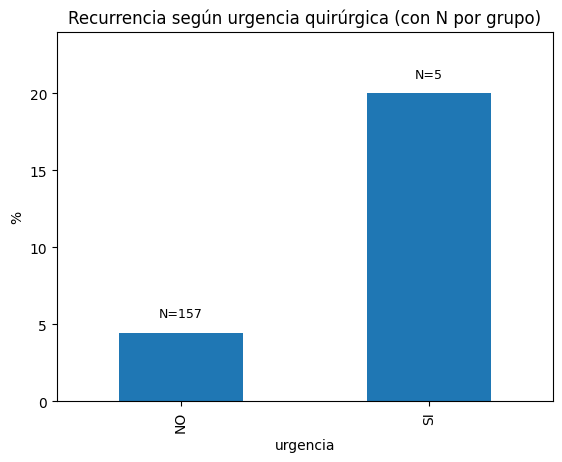

In [261]:
plot_group_proportion_with_n(
    df_filtered,
    group_col="urgencia",
    outcome_col="tiene_recurrencia",
    title="Recurrencia según urgencia quirúrgica (con N por grupo)"
)

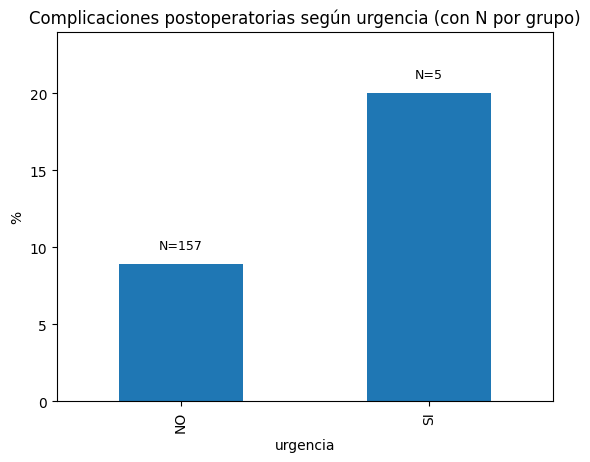

In [262]:
plot_group_proportion_with_n(
    df_filtered,
    group_col="urgencia",
    outcome_col="tuvo_complicacion",
    title="Complicaciones postoperatorias según urgencia (con N por grupo)"
)

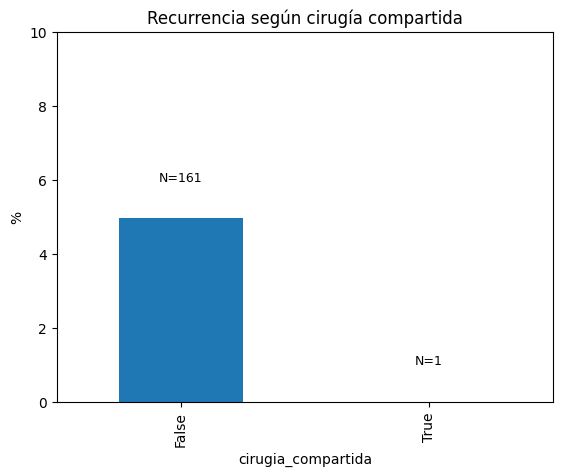

In [263]:
plot_group_proportion_with_n(
    df_filtered,
    group_col="cirugia_compartida",
    outcome_col="tiene_recurrencia",
    title="Recurrencia según cirugía compartida"
)


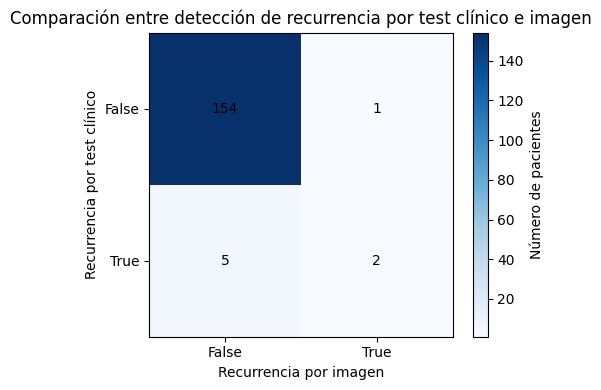

In [264]:

df_filtered["recurrencia_test"] = df_filtered["recurrencia_tipo"].isin(
    ["test", "imagen+test"]
)

df_filtered["recurrencia_imagen"] = df_filtered["recurrencia_tipo"].isin(
    ["imagen", "imagen+test"]
)
confusion = pd.crosstab(
    df_filtered["recurrencia_test"],
    df_filtered["recurrencia_imagen"],
    rownames=["Test (+)"],
    colnames=["Imagen (+)"]
)

plt.figure(figsize=(5, 4))
plt.imshow(confusion, cmap="Blues")

# Axis ticks
plt.xticks(range(len(confusion.columns)), confusion.columns)
plt.yticks(range(len(confusion.index)), confusion.index)

# Axis labels
plt.xlabel("Recurrencia por imagen")
plt.ylabel("Recurrencia por test clínico")

# Cell values
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        plt.text(
            j, i,
            confusion.iloc[i, j],
            ha="center",
            va="center",
            color="black",
            fontsize=10
        )

plt.title("Comparación entre detección de recurrencia por test clínico e imagen")
plt.colorbar(label="Número de pacientes")
plt.tight_layout()
plt.show()



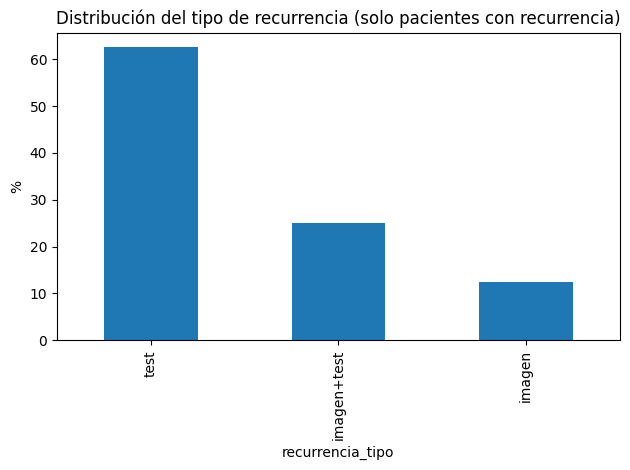

In [265]:
(df_filtered
 .loc[df_filtered["recurrencia_tipo"] != "no", "recurrencia_tipo"]
 .value_counts(normalize=True)
 .mul(100)
 .plot(kind="bar")
)

plt.ylabel("%")
plt.title("Distribución del tipo de recurrencia (solo pacientes con recurrencia)")
plt.tight_layout()
plt.show()



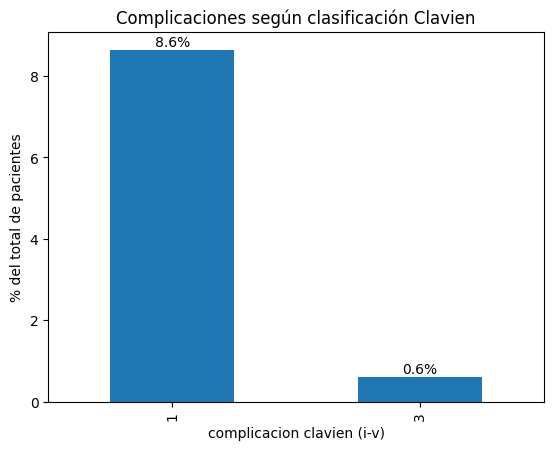

In [266]:

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

series = df_filtered["complicacion clavien (i-v)"]

true_total = series.notna().sum()

plot_series = series.dropna().loc[lambda s: s != "-"]

absolute_counts = plot_series.value_counts().sort_index()
true_percent = absolute_counts / true_total * 100

ax = true_percent.plot(kind="bar")

for i, (idx, pct) in enumerate(true_percent.items()):
    ax.annotate(
        f"{pct:.1f}%",
        (i, pct),
        ha="center",
        va="bottom"
    )

plt.ylabel("% del total de pacientes")
plt.title("Complicaciones según clasificación Clavien")
plt.show()



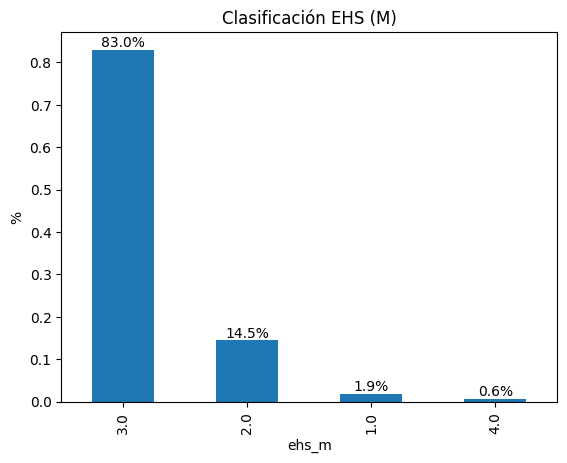

In [267]:
plot_bar(
    df_filtered.loc[df_filtered["ehs_m"].notna(), "ehs_m"],
    "Clasificación EHS (M)"
)

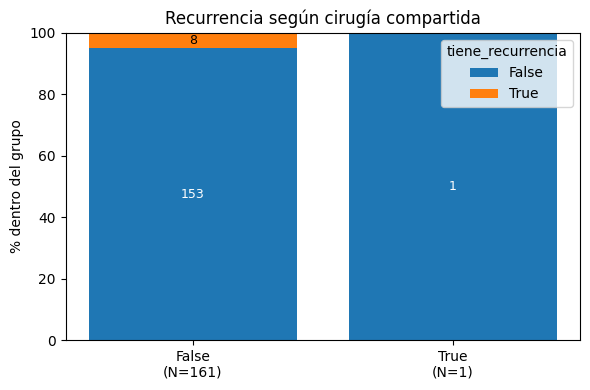

In [268]:
plot_stacked_bar(
    df_filtered,
    group_col="cirugia_compartida",
    outcome_col="tiene_recurrencia",
    title="Recurrencia según cirugía compartida"
)


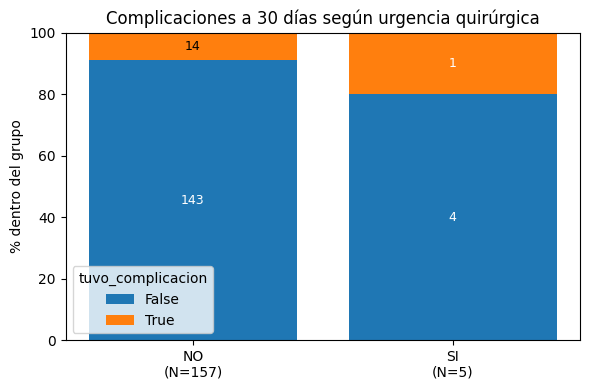

In [269]:
plot_stacked_bar(
    df_filtered,
    group_col="urgencia",
    outcome_col="tuvo_complicacion",
    title="Complicaciones a 30 días según urgencia quirúrgica"
)


=== COMPLICACIONES: URGENCIA vs ELECTIVA ===
tuvo_complicacion  False  True 
urgencia                       
NO                   143     14
SI                     4      1
Odds Ratio: 2.55
Fisher p-value: 0.3887
Riesgo electiva: 8.92%
Riesgo urgencia: 20.00%
Diferencia absoluta de riesgo: 11.08%


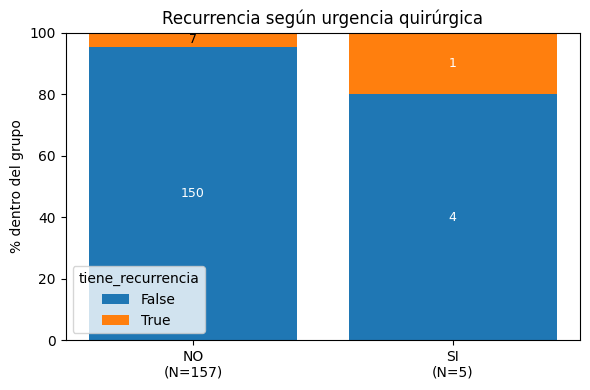

In [270]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact

# =========================
# TABLA DE CONTINGENCIA
# =========================
tab = pd.crosstab(
    df_filtered["urgencia"],
    df_filtered["tuvo_complicacion"]
)

# Asegurar orden lógico
tab = tab.reindex(index=["NO", "SI"], columns=[False, True])

# =========================
# ESTADÍSTICA
# =========================
oddsratio, p = fisher_exact(tab)

risk_elec = tab.loc["NO", True] / tab.loc["NO"].sum()
risk_urg  = tab.loc["SI", True] / tab.loc["SI"].sum()
risk_d = risk_urg - risk_elec

print("=== COMPLICACIONES: URGENCIA vs ELECTIVA ===")
print(tab)
print(f"Odds Ratio: {oddsratio:.2f}")
print(f"Fisher p-value: {p:.4f}")
print(f"Riesgo electiva: {risk_elec*100:.2f}%")
print(f"Riesgo urgencia: {risk_urg*100:.2f}%")
print(f"Diferencia absoluta de riesgo: {risk_d*100:.2f}%")
plot_stacked_bar(
    df_filtered,
    group_col="urgencia",
    outcome_col="tiene_recurrencia",
    title="Recurrencia según urgencia quirúrgica"
)


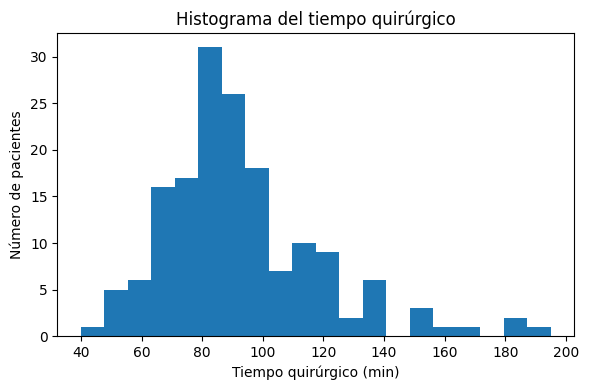

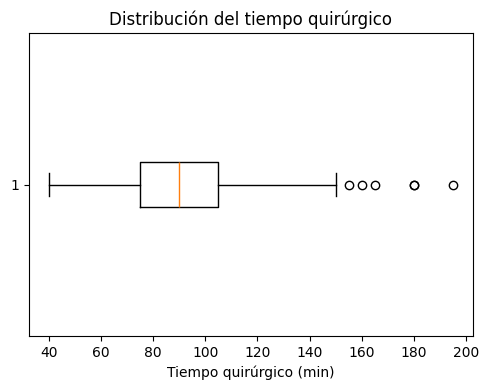


===== TIEMPO QUIRÚRGICO EN CIRUGÍA ELECTIVA SIN CIRUGÍA ADICIONAL =====


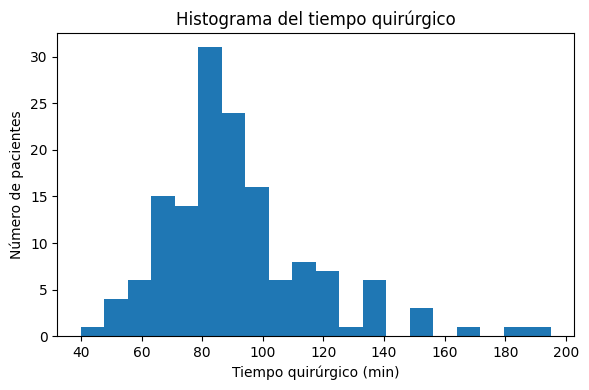

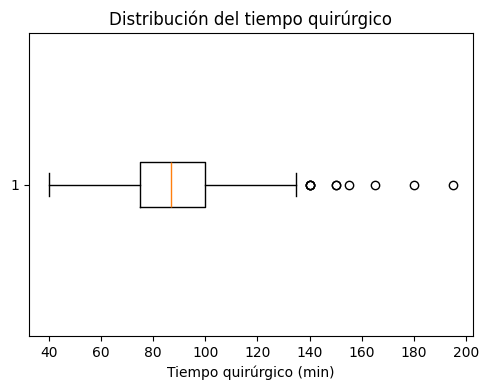


=== TIEMPO QUIRÚRGICO: COMPLEJIDAD VS BASE ===
Grupo base (electiva, cx única): N=145
  Mediana: 87.0 min
  IQR: 75.0–100.0

Grupo con urgencia o cx adicional: N=17
  Mediana: 100.0 min
  IQR: 75.0–120.0

Mann–Whitney U p-value CIRUGIA ADICIONA+URGENCIA: 0.0037

Mann–Whitney U p-value: SOLO URGENCIA 0.1247

Mann–Whitney U p-value: SOLO CIRUGÍA ADICIONAL 0.0037
(17,)
91.26896551724138
(150,)
90.89333333333333


In [284]:

plot_tiempo_qx_hist(df_filtered)
plot_tiempo_qx_box(df_filtered)

df_qx_NOADD = df_filtered[(df_filtered["urgencia"] == "NO") &(df_filtered["cirugia_adicional_flag"] == False)].copy()

print("\n===== TIEMPO QUIRÚRGICO EN CIRUGÍA ELECTIVA SIN CIRUGÍA ADICIONAL =====")


plot_tiempo_qx_hist(df_qx_NOADD)
plot_tiempo_qx_box(df_qx_NOADD)

from scipy.stats import mannwhitneyu
import numpy as np

# ============================
# DEFINIR GRUPOS
# ============================

# Grupo base: electiva + sin cirugía adicional
base = df_filtered[
    (df_filtered["urgencia"] == "NO") &
    (df_filtered["cirugia_adicional_flag"] == False)
]["tiempo_qx_min"].dropna()

# Grupo con complejidad: urgencia OR cirugía adicional
complexo = df_filtered[
    (df_filtered["urgencia"] == "SI") |
    (df_filtered["cirugia_adicional_flag"] == True)
]["tiempo_qx_min"].dropna()

# ============================
# DESCRIPTIVOS
# ============================

print("\n=== TIEMPO QUIRÚRGICO: COMPLEJIDAD VS BASE ===")
print(f"Grupo base (electiva, cx única): N={len(base)}")
print(f"  Mediana: {np.median(base):.1f} min")
print(f"  IQR: {base.quantile(0.25):.1f}–{base.quantile(0.75):.1f}")

print(f"\nGrupo con urgencia o cx adicional: N={len(complexo)}")
print(f"  Mediana: {np.median(complexo):.1f} min")
print(f"  IQR: {complexo.quantile(0.25):.1f}–{complexo.quantile(0.75):.1f}")

# ============================
# TEST ESTADÍSTICO
# ============================

u, p1 = mannwhitneyu(base, complexo, alternative="two-sided")

print(f"\nMann–Whitney U p-value CIRUGIA ADICIONA+URGENCIA: {p:.4f}")

# Urgencia sola
urg = df_filtered[df_filtered["urgencia"] == "SI"]["tiempo_qx_min"].dropna()

# Cirugía adicional sola (sin urgencia)
add = df_filtered[
    (df_filtered["cirugia_adicional_flag"] == True) &
    (df_filtered["urgencia"] == "NO")
]["tiempo_qx_min"].dropna()

u, p = mannwhitneyu(base, urg, alternative="two-sided")

print(f"\nMann–Whitney U p-value: SOLO URGENCIA {p:.4f}")

u, p = mannwhitneyu(base, add, alternative="two-sided")

print(f"\nMann–Whitney U p-value: SOLO CIRUGÍA ADICIONAL {p:.4f}")  

print(complexo.shape)

print(base.mean())
base_urg = df_filtered[
    (df_filtered["cirugia_adicional_flag"] == False)
]["tiempo_qx_min"].dropna()

print(base_urg.shape)
print(base_urg.mean())

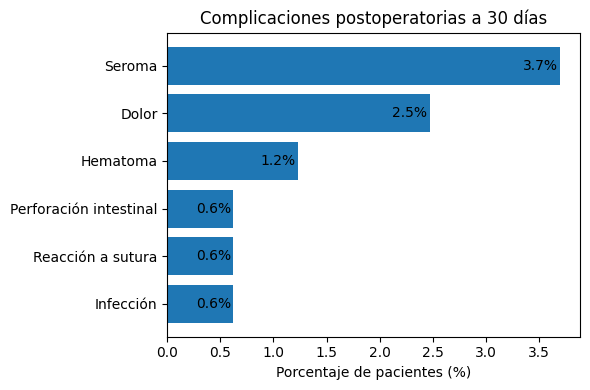

In [272]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    "Seroma": 3.70,
    "Dolor": 2.47,
    "Hematoma": 1.23,
    "Infección": 0.62,
    "Reacción a sutura": 0.62,
    "Perforación intestinal": 0.62
}

df = pd.Series(data).sort_values()

plt.figure(figsize=(6,4))
plt.barh(df.index, df.values)
plt.xlabel("Porcentaje de pacientes (%)")
plt.title("Complicaciones postoperatorias a 30 días")

for i, v in enumerate(df.values):
    plt.text(v-0.35 , i, f"{v:.1f}%", va="center")

plt.tight_layout()
plt.show()


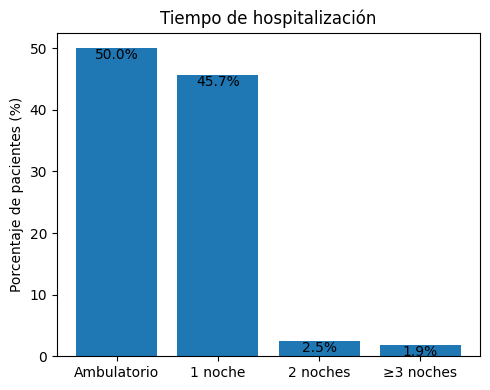

In [273]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    "Ambulatorio": 50.00,
    "1 noche": 45.68,
    "2 noches": 2.47,
    "≥3 noches": 1.85
}

df = pd.Series(data)

plt.figure(figsize=(5,4))
plt.bar(df.index, df.values)
plt.ylabel("Porcentaje de pacientes (%)")
plt.title("Tiempo de hospitalización")

for i, v in enumerate(df.values):
    plt.text(i, v-1.77, f"{v:.1f}%", ha="center")

plt.tight_layout()
plt.show()



=== COMPLICACIONES vs RECURRENCIA ===
tiene_recurrencia  False  True 
tuvo_complicacion              
False                141      6
True                  13      2
Odds Ratio: 3.62
Fisher p-value: 0.1618
Riesgo con complicaciones: 13.33%
Riesgo sin complicaciones: 4.08%
Diferencia absoluta de riesgo: 9.25%


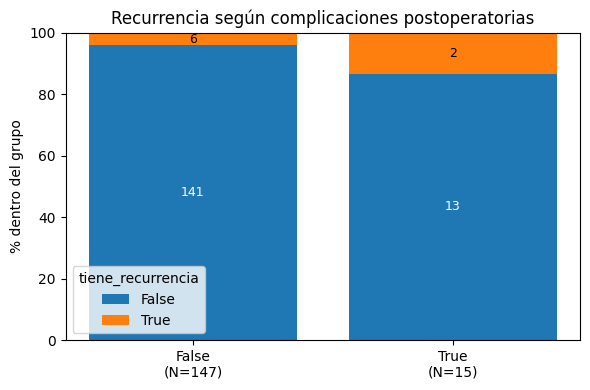

In [274]:
tab_comp_rec = pd.crosstab(
    df_filtered["tuvo_complicacion"],
    df_filtered["tiene_recurrencia"]
)

or_val, p_val = fisher_from_crosstab(tab_comp_rec)

print("\n=== COMPLICACIONES vs RECURRENCIA ===")
print(tab_comp_rec)
print(f"Odds Ratio: {or_val:.2f}")
print(f"Fisher p-value: {p_val:.4f}")

r1, r0, rd = risk_diff(tab_comp_rec)
print(f"Riesgo con complicaciones: {r1*100:.2f}%")
print(f"Riesgo sin complicaciones: {r0*100:.2f}%")
print(f"Diferencia absoluta de riesgo: {rd*100:.2f}%")


plot_stacked_bar(
    df_filtered,
    group_col="tuvo_complicacion",
    outcome_col="tiene_recurrencia",
    title="Recurrencia según complicaciones postoperatorias"
)


=== ORIGEN DE HERNIA vs RECURRENCIA ===
tiene_recurrencia  False  True 
hernia_origen                  
primaria             146      5
recidivada             8      3
Odds Ratio: 10.95
Fisher p-value: 0.0110


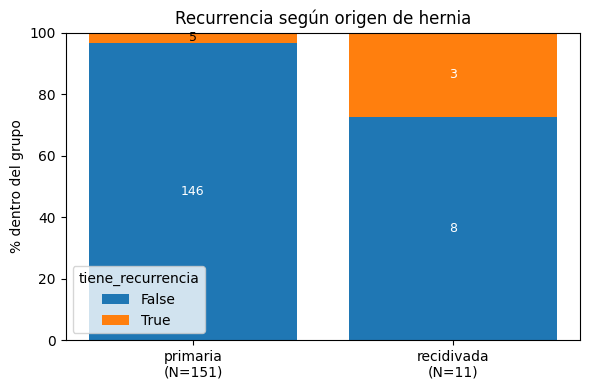

In [275]:
tab_origen_rec = pd.crosstab(
    df_filtered["hernia_origen"],
    df_filtered["tiene_recurrencia"]
)

print("\n=== ORIGEN DE HERNIA vs RECURRENCIA ===")
print(tab_origen_rec)

if tab_origen_rec.shape == (2,2):
    or_val, p_val = fisher_from_crosstab(tab_origen_rec)
    print(f"Odds Ratio: {or_val:.2f}")
    print(f"Fisher p-value: {p_val:.4f}")

plot_stacked_bar(
    df_filtered,
    group_col="hernia_origen",
    outcome_col="tiene_recurrencia",
    title="Recurrencia según origen de hernia"
)



=== INCISIONAL vs NO INCISIONAL → RECURRENCIA ===
tiene_recurrencia  False  True 
es_incisional                  
False                124      5
True                  30      3
Odds Ratio: 2.48
Fisher p-value: 0.2072


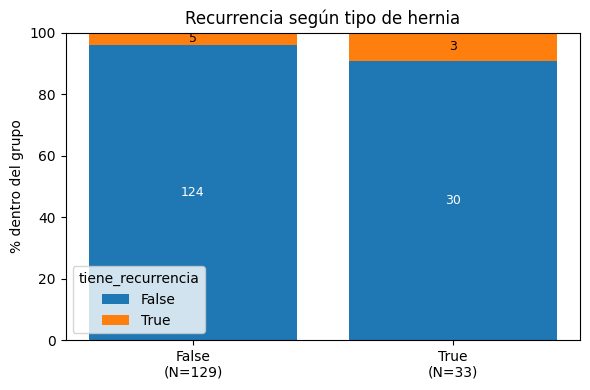

In [276]:
df_filtered["es_incisional"] = df_filtered["hernia_tipo"] == "incisional"

tab_incisional = pd.crosstab(
    df_filtered["es_incisional"],
    df_filtered["tiene_recurrencia"]
)

or_val, p_val = fisher_from_crosstab(tab_incisional)

print("\n=== INCISIONAL vs NO INCISIONAL → RECURRENCIA ===")
print(tab_incisional)
print(f"Odds Ratio: {or_val:.2f}")
print(f"Fisher p-value: {p_val:.4f}")

plot_stacked_bar(
    df_filtered,
    group_col="es_incisional",
    outcome_col="tiene_recurrencia",
    title="Recurrencia según tipo de hernia"
)



In [277]:
tab_urg_rec = pd.crosstab(
    df_filtered["urgencia"],
    df_filtered["tiene_recurrencia"]
)

or_val, p_val = fisher_from_crosstab(tab_urg_rec)

print("\n=== URGENCIA vs ELECTIVA → RECURRENCIA ===")
print(tab_urg_rec)
print(f"Odds Ratio: {or_val:.2f}")
print(f"Fisher p-value: {p_val:.4f}")

r1, r0, rd = risk_diff(tab_urg_rec)
print(f"Riesgo urgencia: {r1*100:.2f}%")
print(f"Riesgo electiva: {r0*100:.2f}%")
print(f"Diferencia absoluta de riesgo: {rd*100:.2f}%")



=== URGENCIA vs ELECTIVA → RECURRENCIA ===
tiene_recurrencia  False  True 
urgencia                       
NO                   150      7
SI                     4      1
Odds Ratio: 5.36
Fisher p-value: 0.2262
Riesgo urgencia: 20.00%
Riesgo electiva: 4.46%
Diferencia absoluta de riesgo: 15.54%


In [278]:
tab_combo_rec = pd.crosstab(
    df_filtered["cirugia_compartida"],
    df_filtered["tiene_recurrencia"]
)

or_val, p_val = fisher_from_crosstab(tab_combo_rec)

print("\n=== CIRUGÍA COMPARTIDA vs SOLA → RECURRENCIA ===")
print(tab_combo_rec)
print(f"Odds Ratio: {or_val:.2f}")
print(f"Fisher p-value: {p_val:.4f}")




=== CIRUGÍA COMPARTIDA vs SOLA → RECURRENCIA ===
tiene_recurrencia   False  True 
cirugia_compartida              
False                 153      8
True                    1      0
Odds Ratio: 0.00
Fisher p-value: 1.0000



=== TIEMPO QUIRÚRGICO: URGENCIA vs ELECTIVA ===
N urgencia: 5 | Mediana: 75.0
N electiva: 157 | Mediana: 90.0
Mann–Whitney U p-value: 0.1086


C:\Users\simon\AppData\Local\Temp\ipykernel_11108\1747680917.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


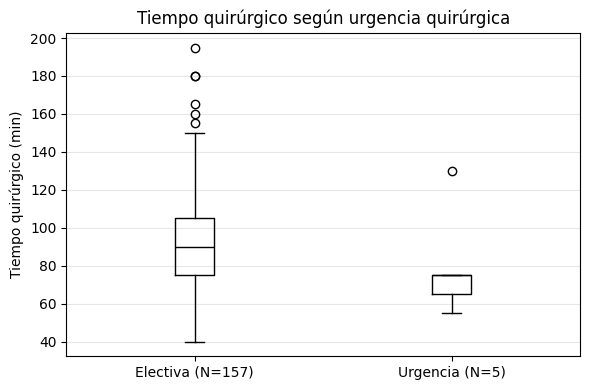

In [279]:
urg = df_filtered[df_filtered["urgencia"] == "SI"]["tiempo_qx_min"].dropna()
elec = df_filtered[df_filtered["urgencia"] == "NO"]["tiempo_qx_min"].dropna()

u, p = mannwhitneyu(urg, elec, alternative="two-sided")

print("\n=== TIEMPO QUIRÚRGICO: URGENCIA vs ELECTIVA ===")
print(f"N urgencia: {len(urg)} | Mediana: {np.median(urg):.1f}")
print(f"N electiva: {len(elec)} | Mediana: {np.median(elec):.1f}")
print(f"Mann–Whitney U p-value: {p:.4f}")

import matplotlib.pyplot as plt

data = [
    elec,
    urg
]

labels = [
    f"Electiva (N={len(elec)})",
    f"Urgencia (N={len(urg)})"
]

plt.figure(figsize=(6, 4))
plt.boxplot(
    data,
    labels=labels,
    showfliers=True,
    medianprops=dict(color="black")
)

plt.ylabel("Tiempo quirúrgico (min)")
plt.title("Tiempo quirúrgico según urgencia quirúrgica")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()



In [280]:
rec_only = df_filtered[df_filtered["tiene_recurrencia"]]

print("\n=== DISTRIBUCIÓN TIPO DE RECURRENCIA (SOLO RECURRENCIA) ===")
print(
    rec_only["recurrencia_tipo"]
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
)



=== DISTRIBUCIÓN TIPO DE RECURRENCIA (SOLO RECURRENCIA) ===
recurrencia_tipo
test           62.5
imagen+test    25.0
imagen         12.5
Name: proportion, dtype: float64
